# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print("hi")

hi


In [4]:
# stdlib
import os
import shutil
import sqlite3

# 3rd party
import ipyparallel as ipp
import ipyvolume as ipv
import ipywidgets as ipw
import numpy as np
from scipy.optimize import minimize
import sympy as sp
import sympy.parsing.latex
import matplotlib.pyplot as plt
import matplotlib as mpl

# local
import convergence as conv
import kelp_analyze
import kelp_compute
import mms
import discrete_plot
import run_utils as ru

/home/jovyan/scratch/kelp/code/python/kelp_compute.py:32: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [5]:
sp.init_printing()
%matplotlib inline

---

# User-function definitions

In [6]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [7]:
def linear_vsf(delta):
    """Defined on [-1, 1]."""
    return (delta+1)/(4*sp.pi)

In [8]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        * (2+sp.sin(phi))
    )

In [9]:
def exp_L(x, y, z, theta, phi, b, alpha, gamma):
    return sp.exp(-2*z) - sp.exp(2*b*gamma)

In [10]:
def expb_L(x, y, z, theta, phi, b, alpha, gamma):
    return gamma*sp.exp(-2*b*z) - z*sp.exp(-2*b*gamma)

In [11]:
def expb15_L(x, y, z, theta, phi, b, alpha, gamma):
    return gamma**1.5*sp.exp(-2*b*z) - z**1.5*sp.exp(-2*b*gamma)

In [12]:
def down_L(x, y, z, theta, phi, b, alpha, gamma):
    return sp.Piecewise((sp.exp(-z), phi<sp.pi/2), (0, True))

In [13]:
def zero_L(x, y, z, theta, phi, b, alpha, gamma):
    return 0 * sp.Symbol('x')

In [14]:
def uniform_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha

In [15]:
def unisinb_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha*(1+sp.sin(b))

In [16]:
def tanh_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha * (2+sp.sin(z/10)) * sp.tanh((gamma-z)/10) * z * (2+sp.sin(4*sp.pi*x/alpha) + sp.sin(4*sp.pi*y/alpha)) / 5

In [17]:
def tanh_b_L(x, y, z, theta, phi, b, alpha, gamma):
    """
    alpha = rope_spacing
    gamma = zmax
    """
    return (
        alpha * (z-gamma+sp.tanh((1+b)*(gamma-z)) / sp.tanh((1+b)*gamma))
        * (1+z*(sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha)))
        *(1+sp.sin(theta+phi))
    )

In [18]:
def tanh_b_L_smallderiv(x, y, z, theta, phi, b, alpha, gamma):
    """
    alpha = rope_spacing
    gamma = zmax
    """
    return (
        alpha * (z/10-gamma/10+sp.tanh((1+b)*(gamma-z)/10) / sp.tanh((1+b)*gamma/10))
        * (1+z/10*(sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha)))
        *(1+sp.sin(theta+phi)/10)
    )

In [19]:
def prod_a(x, y, z, alpha, gamma):
    return 1 + (3+sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha)) + (1+sp.tanh(z-gamma))

In [20]:
def prod_a_smallderiv(x, y, z, alpha, gamma):
    return 1 + (3+sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha))/10 + (1+sp.tanh(z-gamma))

In [21]:
def uniform_a(x, y, z, alpha, gamma):
    return 0.2

In [22]:
def inv_a(x, y, z, alpha, gamma):
    return 1/tanh_L(x, y, z, 0, 0, 0, alpha, gamma)

### Decide here which functions to use.

In [23]:
sol_func = tanh_b_L
abs_func = prod_a
vsf_func = linear_vsf

---

# Symbolic Calculations

## Calculate source & BC

In [24]:
b = sp.var('b')
params = sp.var('alpha, gamma')

source_expr = mms.calculate_source(sol_func, b, abs_func, vsf_func, params)
bc_expr = mms.calculate_bc(sol_func, b, params)

# Evaluate other expressions as well for consistency
sol_expr = sol_func(*mms.space, *mms.angle, b, *params)
abs_expr = abs_func(*mms.space, *params)
vsf_expr = vsf_func(mms.delta)

## Specify parameter values

In [25]:
# Domain size
rope_spacing = 1
zmax = 1
b = 0.5

param_vals = {
    'alpha': rope_spacing,
    'gamma': zmax,
    'b': b
}

## Generate symbolic and numerical functions

In [26]:
# Generate symbolic functions
source_sym = mms.symify(source_expr, *mms.space, *mms.angle, **param_vals)
abs_sym = mms.symify(abs_expr, *mms.space, **param_vals)
bc_sym = mms.symify(bc_expr, *mms.angle, **param_vals)
vsf_sym = mms.symify(vsf_expr, mms.delta, **param_vals)
sol_sym = mms.symify(sol_expr, *mms.space, *mms.angle, **param_vals)

# Generate numerical functions
abs_func_N = mms.sym_to_num(abs_sym, *mms.space)
source_func_N = mms.sym_to_num(source_sym, *mms.space, *mms.angle)
bc_func_N = mms.sym_to_num(bc_sym, *mms.angle)
vsf_func_N = mms.sym_to_num(vsf_sym, mms.delta)
sol_func_N = mms.sym_to_num(sol_sym, *mms.space, *mms.angle)

## Problem Summary

Solution


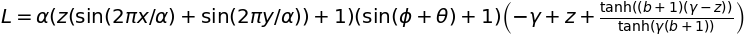


Absorption Coefficient



VSF


Boundary Condition



Source


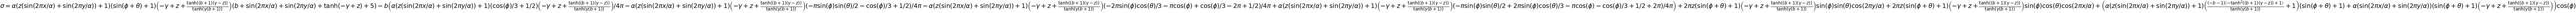

In [27]:
print("Solution")
mms.display_eq('L', sol_expr)
print()

print("Absorption Coefficient")
mms.display_eq('a', abs_expr)
print()

print("VSF")
mms.display_eq('beta', vsf_expr)

print("Boundary Condition")
mms.display_eq('L_0', bc_expr)
print()

print("Source")
mms.display_eq('sigma', source_expr)
print()

In [28]:
source_mod = sp.parsing.latex.parse_latex(r"""  
  {\alpha} ({z} (\sin{ (\frac{2 {\pi} x}{{\alpha}}  )} + \sin{ (\frac{2 {\pi} y}{{\alpha}}  )}) + 1) (\sin{ (\phi + \theta  )} + 1) 
  \cdot (- {\gamma} + {z} + \frac{\tanh{ ((b + 1) ({\gamma} - {z})  )}}{\tanh{ ({\gamma} (b + 1)  )}}) (b + \sin{ (\frac{2 {\pi} x}{{\alpha}}  )} + \sin{ (\frac{2 {\pi} y}{{\alpha}}  )} + \tanh{ (- {\gamma} + {z}  )} + 5) 
  - b [ \frac{{\alpha} ({z} (\sin{ (\frac{2 {\pi} x}{{\alpha}}  )} + \sin{ (\frac{2 {\pi} y}{{\alpha}}  )}) + 1) (\frac{\sin{ (\phi  )} \sin{ (\theta  )}}{3} + \frac{\cos{ (\phi  )}}{3}) (- {\gamma} + {z} + \frac{\tanh{ ((b + 1) ({\gamma} - {z})  )}}{\tanh{ ({\gamma} (b + 1)  )}})}{4 {\pi}} 
  - \frac{{\alpha} ({z} (\sin{ (\frac{2 {\pi} x}{{\alpha}}  )} + \sin{ (\frac{2 {\pi} y}{{\alpha}}  )}) + 1) (- {\gamma} + {z} + \frac{\tanh{ ((b + 1) ({\gamma} - {z})  )}}{\tanh{ ({\gamma} (b + 1)  )}})}{4 {\pi}} 
    \cdot (-\frac{{\pi} \sin{( \phi )}\sin{( \theta )}}{2} - \frac{\sin{ (\phi  )} \sin{ (\theta  )}}{3} - \frac{\cos{ (\phi  )}}{3}) 
  - \frac{{\alpha} ({z} (\sin{ (\frac{2 {\pi} x}{{\alpha}}  )} + \sin{ (\frac{2 {\pi} y}{{\alpha}}  )}) + 1) (- {\gamma} + {z} + \frac{\tanh{ ((b + 1) ({\gamma} - {z})  )}}{\tanh{ ({\gamma} (b + 1)  )}})}{4 {\pi}} 
    \cdot (\frac{\sin{( \phi )}\sin{( \theta )}}{3} - \frac{2 {\pi} \sin{ (\phi  )} \cos{ (\theta  )}}{3} + \frac{\cos{ (\phi  )}}{3} - 2 {\pi}) 
  + \frac{{\alpha} ({z} (\sin{ (\frac{2 {\pi} x}{{\alpha}}  )} + \sin{ (\frac{2 {\pi} y}{{\alpha}}  )}) + 1) (- {\gamma} + {z} + \frac{\tanh{ ((b + 1) ({\gamma} - {z})  )}}{\tanh{ ({\gamma} (b + 1)  )}})}{4 {\pi}} 
  \cdot (- \frac{{\pi} \sin{ (\phi  )} \sin{ (\theta  )}}{2} - \frac{\sin{(\phi)}\sin{(\theta)}}{3} + \frac{2 {\pi} \sin{ (\phi  )} \cos{ (\theta  )}}{3} - \frac{\cos{ (\phi  )}}{3} + 2 {\pi}) ] 
  + 2 {\pi} {z} (\sin{ (\phi + \theta  )} + 1) (- {\gamma} + {z} + \frac{\tanh{ ((b + 1) ({\gamma} - {z})  )}}{\tanh{ ({\gamma} (b + 1)  )}}) \sin{ (\phi  )} \sin{ (\theta  )} \cos{ (\frac{2 {\pi} y}{{\alpha}}  )} 
  + 2 {\pi} {z} (\sin{ (\phi + \theta  )} + 1) (- {\gamma} + {z} + \frac{\tanh{ ((b + 1) ({\gamma} - {z})  )}}{\tanh{ ({\gamma} (b + 1)  )}}) \sin{ (\phi  )} \cos{ (\theta  )} \cos{ (\frac{2 {\pi} x}{{\alpha}}  )} 
  + [{\alpha} ({z} (\sin{ (\frac{2 {\pi} x}{{\alpha}}  )} + \sin{ (\frac{2 {\pi} y}{{\alpha}}  )}) + 1) 
  \cdot (\frac{(- b - 1) (- \tanh^{2}{ ((b + 1) ({\gamma} - {z})  )} + 1)}{\tanh{ ({\gamma} (b + 1)  )}} + 1) 
  (\sin{ (\phi + \theta  )} + 1) 
  + {\alpha} (\sin{ (\frac{2 {\pi} x}{{\alpha}}  )} + \sin{ (\frac{2 {\pi} y}{{\alpha}}  )}) (\sin{ (\phi + \theta  )} + 1) 
  \cdot (- {\gamma} + {z} + \frac{\tanh{ ((b + 1) ({\gamma} - {z})  )}}{\tanh{ ({\gamma} (b + 1)  )}})] \cos{ (\phi  )}
""", )

/opt/conda/lib/python3.6/site-packages/sympy/external/importtools.py:145: UserWarning: antlr4.error.ErrorListener module is not installed
  warnings.warn("%s module is not installed" % module, UserWarning)
/opt/conda/lib/python3.6/site-packages/sympy/external/importtools.py:145: UserWarning: antlr4 module is not installed
  warnings.warn("%s module is not installed" % module, UserWarning)


ImportError: LaTeX parsing requires the antlr4 python package, provided by pip (antlr4-python2-runtime or antlr4-python3-runtime) or conda (antlr-python-runtime)

In [ ]:
source_mod

In [ ]:
symbols = list((source_expr - source_mod).free_symbols)
symbols

In [ ]:
source_expr.free_symbols

In [ ]:
source_mod.free_symbols

In [ ]:
list((source_expr - source_mod).free_symbols)[4] == sp.Symbol('gamma')

In [ ]:
sp.N((source_expr - source_mod).subs((
    ('x', 1.45), #x
    ('y', 2.64), #y
    ('z', 7.54),#z
    ('theta', 1.22), #theta
    ('phi', 0.64), #phi
    ('gamma', 10), #gamma
    ('alpha', 6), #alpha
    ('b', 1.32)), #b
)).subs('pi', np.pi)

---

# Symbolic Analysis

## Check solution constraints

- Everything is periodic in x, y
- Absorption coefficient is positive
- Boundary condition depends only on angle
- No upwelling light from below
- Properly normalized VSF

In [27]:
# Check bottom BC
print('bottom:', sp.expand(sol_expr.subs('z',sp.Symbol('gamma'))) == 0)

# Check periodicity
smax = sp.Symbol('alpha')/2
smin = -smax
print('sol x:', sp.expand(sol_expr.subs('x',smax) - sol_expr.subs('x',smin)) == 0)
print('sol y:', sp.expand(sol_expr.subs('y',smax) - sol_expr.subs('y',smin)) == 0)
print('abs x:', sp.expand(abs_expr.subs('x',smax) - abs_expr.subs('x',smin)) == 0)
print('abs y:', sp.expand(abs_expr.subs('y',smax) - abs_expr.subs('y',smin)) == 0)

# Check VSF normalization (Should be 1 over whole sphere, or 1/(2pi) on [-1, 1].)
print(
    "VSF:",
    1 == sp.expand(
        mms.sphere_integral(
            vsf_expr.subs(
                'Delta', 
                mms.dot(
                    mms.vec_om, 
                    mms.vec_omp)
            ), 
            angle=mms.angle
        )
    )
)

bottom: True
sol x: True
sol y: True
abs x: True
abs y: True
VSF: True


## Check source term

If source term appears nonzero, try substituting parameters,
then plugging in analytical solution.

The result should be 0.

In [28]:
diff = mms.check_sol(sol_sym, b, abs_sym, vsf_sym, source_sym)
diff

In [29]:
num_diff = sp.lambdify(
    (*mms.space, *mms.angle),
    diff,
    modules=("numpy",)
)

In [30]:
# Check numerical max on grid in case of numerical error in above expression
np.max(num_diff(*mms.gen_grid(10, 10, 10, 10, 1, 1)))


## Examine solution dervatives

In [31]:
conv.max_derivs(sol_expr, rope_spacing, zmax, do_space=True, do_angle=True, **param_vals)

{'x': 1.413505298329503,
 'y': 1.413505298329503,
 'z': 3.6258993880023818,
 'theta': 0.41979790295292774,
 'phi': 0.41979790295292774}

In [32]:
conv.max_derivs(abs_expr, rope_spacing, zmax, do_space=True, do_angle=False, **param_vals)

{'x': 5.975664329483112, 'y': 5.975664329483112, 'z': 0.9975041607715679}

In [33]:
conv.max_derivs(source_expr, rope_spacing, zmax, do_space=True, do_angle=True, **param_vals)

{'x': 16.051404489899543,
 'y': 14.757777825274077,
 'z': 32.77080789466493,
 'theta': 3.465582732419481,
 'phi': 3.925048732767275}

## LaTeX output

In [35]:
sp.print_latex(sol_expr)

\alpha \left(z \left(\sin{\left (\frac{2 \pi x}{\alpha} \right )} + \sin{\left (\frac{2 \pi y}{\alpha} \right )}\right) + 1\right) \left(\sin{\left (\phi + \theta \right )} + 1\right) \left(- \gamma + z + \frac{\tanh{\left (\left(b + 1\right) \left(\gamma - z\right) \right )}}{\tanh{\left (\gamma \left(b + 1\right) \right )}}\right)


In [36]:
sp.print_latex(abs_expr)

\sin{\left (\frac{2 \pi x}{\alpha} \right )} + \sin{\left (\frac{2 \pi y}{\alpha} \right )} + \tanh{\left (- \gamma + z \right )} + 5


In [37]:
sp.print_latex(vsf_expr)

\frac{\Delta + 1}{4 \pi}


In [ ]:
sp.print_latex(source_expr)

In [39]:
sp.print_latex(bc_expr)

\alpha \left(- \gamma + 1\right) \left(\sin{\left (\phi + \theta \right )} + 1\right)


---

# FD Verification

## IPyParallel Setup

In [33]:
#remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
[3, 4, 5]


In [34]:
ipc.queue_status()

{'unassigned': 0,
 0: {'queue': 0, 'completed': 29, 'tasks': 0},
 1: {'queue': 0, 'completed': 29, 'tasks': 0},
 2: {'queue': 0, 'completed': 2, 'tasks': 0},
 3: {'queue': 0, 'completed': 0, 'tasks': 0},
 4: {'queue': 0, 'completed': 0, 'tasks': 0},
 5: {'queue': 0, 'completed': 0, 'tasks': 0}}

In [35]:
print("hi")

hi


## Single Space

### Compute

In [ ]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

na = 8

#ns_list = [4, 8, 16, 32, 64]
ns_list = np.linspace(10, 100, 10).astype(int)
#ns_list = [4, 8, 12, 16, 20]

study_name = 'verify_fd_ss_{}x{}_nsm1'.format(max(ns_list), na)
study_dir = os.path.join(base_dir, study_name)

ntheta = na
nphi = na

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = -1
fd_flag = True
num_threads = 32

b = 0.5
param_vals['b'] = 0.5

combine_thread, gs_fut = kelp_compute.verify_single_space_compute(
    study_name, 
    ns_list, ntheta, nphi, 
    rope_spacing, zmax, b, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    num_scatters, num_threads, fd_flag,
    param_vals, base_dir=base_dir)

### Plot

In [204]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
study_name = 'verify_fd_ss_64x8'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

In [207]:
compute_time_arr

array([  0,   0,   2,  22, 594])

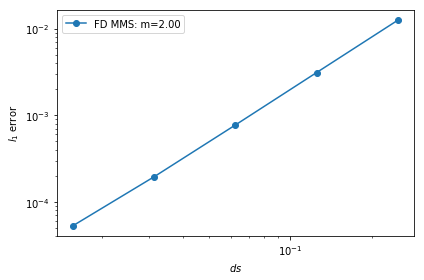

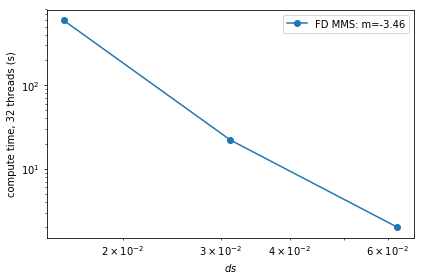

In [210]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

compute_time_arr = np.zeros_like(ns_list)
err_dict = {}
for i, ns in enumerate(ns_list):
    results_list = kelp_analyze.query_results(
        conn, study_name, base_dir,
        ns=ns,
        nz=ns,
    )
    compute_time = results_list[0]['compute_time'][:]
    compute_time_arr[i] = compute_time

    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]

    err = norm(rad - true_rad)
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

m, b = conv.lin_fit(
    np.log(res_arr), np.log(err_arr), 
    min(np.log(res_arr))+.1, max(np.log(res_arr))
)

plt.figure(figsize=(6,4))
plt.loglog(res_arr, err_arr, 'o-', label='FD MMS: m={:.2f}'.format(m))
plt.xlabel(r'$ds$')
plt.ylabel('$l_1$ error')
plt.legend()
plt.tight_layout()
plt.savefig("/scratch/kelp-figures/fd_mms.pdf")

m, b = conv.lin_fit(
    np.log(res_arr[2:]), np.log(compute_time_arr[2:]), 
    min(np.log(res_arr))+.1, max(np.log(res_arr))
)

plt.figure(figsize=(6,4))
plt.loglog(res_arr[2:], compute_time_arr[2:], 'o-', label='FD MMS: m={:.2f}'.format(m))
plt.xlabel(r'$ds$')
plt.ylabel('compute time, 32 threads (s)')
plt.legend()
plt.tight_layout()
plt.savefig("/scratch/kelp-figures/fd_mms_time.pdf")

## Multi-dimensional FD

### Compute

### Plot

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
max_res_list = list(map(
    max,
    dim_resolutions
))
max_res_dict = {
    name: max_res
    for name, max_res in zip(dim_names, max_res_list)
}
dim_dict = dict(zip(dim_names, dim_resolutions))

# Loop over dimensions
for dim_num, dim_name in enumerate(dim_names):
    # List of resolutions in the current dimension
    current_dim = dim_dict[dim_name]
    
    print(dim_name)
    err_dict = {}
    for n in current_dim:
        all_dims = {**max_res_dict, **{dim_name: n}}
        results_list = kelp_analyze.query_results(
            conn, study_name, 
            **all_dims
        )

        rad = results_list[0]['rad'][:]
        true_rad = results_list[0]['true_rad'][:]

        err = norm(rad - true_rad)
        err_dict[n] = err

    res_arr = rope_spacing / np.array(current_dim)
    err_arr = np.array([err_dict[n] for n in current_dim])

    conv.plot_lin_fit(
        np.log(res_arr), np.log(err_arr), 
        min(np.log(res_arr)), max(np.log(res_arr)), 
        xlabel='d'+dim_name[1:], ylabel='err'
    )

# Asymptotics Verification

## Sourceless

### 1D, Uniform abs.

#### Compute

In [ ]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

nz = 20

nz_list = [nz]

study_name = 'verify_asym_noscat_1d_uniform_abs_{}'.format(nz)
study_dir = os.path.join(base_dir, study_name)

noscat_bc_expr = 1.0
noscat_abs_expr = 1.0

ntheta = na
nphi = na

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.verify_asym_noscat_1d_compute(
    study_name, 
    nz_list,
    rope_spacing, zmax, 
    noscat_abs_expr, noscat_bc_expr,
    param_vals, base_dir=base_dir
)

#### Plot

In [ ]:
study_name = 'verify_asym_noscat_1d_uniform_abs_20'
study_dir = os.path.join(base_dir, study_name)

In [ ]:
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

results_list = kelp_analyze.query_results(
    conn, study_name,
)

results = results_list[0]
rad = results['rad'][:][:,:,:,0]
true_rad = results['true_rad'][:][:,:,:,0]

avg_rad = np.mean(rad, axis=(0, 1))
avg_true_rad = np.mean(true_rad, axis=(0, 1))

err = norm(rad - true_rad)

print("err = {:.2f}".format(err))


_, _, z, _, _ = mms.gen_grid(
    *map(
        lambda x: int(results[x][:].data),
        ('ns', 'nz', 'ntheta', 'nphi', 'rope_spacing', 'zmax')
    )
)

z = z[0,0,:,0]

plt.plot(z, avg_rad, 'o-', label='approx.')
plt.plot(z, avg_true_rad, 'o-', label='true')
plt.legend()
plt.xlabel('z')
plt.ylabel('avg rad')

### 1D, Non-uniform abs., increase nz

#### Compute

In [ ]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

nz_list = [4, 8, 12, 20, 40, 100]

study_name = 'verify_asym_noscat_1d_variable_abs_{}'.format(max(nz_list))
study_dir = os.path.join(base_dir, study_name)

noscat_bc_expr = 1.0
noscat_abs_expr = 2 + sp.sin(10*sp.Symbol('z'))

ntheta = na
nphi = na

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.verify_asym_noscat_1d_compute(
    study_name, 
    nz_list,
    rope_spacing, zmax, 
    noscat_abs_expr, noscat_bc_expr,
    param_vals, base_dir=base_dir
)

#### Plot

In [ ]:
study_name = 'verify_asym_noscat_1d_variable_abs_100'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

nz_list = dim_dict['nz']

err_dict = {}
for nz in nz_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        nz=nz,
    )

    rad = results_list[0]['rad'][:,:,:,0]
    true_rad = results_list[0]['true_rad'][:,:,:,0]

    err = norm(rad - true_rad)
    err_dict[nz] = err

res_arr = zmax / np.array(nz_list)
err_arr = np.array([err_dict[nz] for nz in nz_list])

conv.plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='log10 dz', ylabel='log10 err'
)


## Full MMS

### 3D, noscat., const. abs., source

#### Compute

In [ ]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

ns = 20
nz = 20
na = 6

study_name = 'verify_ss_noscat_const_abs_scat_{}x{}x{}'.format(ns, nz, na)
study_dir = os.path.join(base_dir, study_name)

ns_list = [4, 8, 16, 32]
#ns_list = [4, 8, 12, 16, 20]

ntheta = na
nphi = na

sigma = 1
a = 1

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

b = 0
param_vals['b'] = 0

combine_thread, gs_fut = kelp_compute.verify_asym_noscat_const_abs_and_source_compute(
    study_name, 
    ns, nz, ntheta, nphi, 
    a, sigma,
    rope_spacing, zmax,
    param_vals, base_dir=base_dir
)

#### Plot

In [ ]:
study_name = 'verify_ss_noscat_const_abs_scat_20x20x6'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

##### rad. vs. depth

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

plt.figure(1)
plt.figure(2)

results_list = kelp_analyze.query_results(
    conn, study_name,
    ns=ns,
)

results = results_list[0]
nomega = results['nomega'][:]

p = 0 #nomega - 1

rad = results['rad'][:][:,:,:,p]
true_rad = results['true_rad'][:][:,:,:,p]

avg_rad = np.mean(rad, axis=(0, 1))
avg_true_rad = np.mean(true_rad, axis=(0, 1))

err = norm(rad - true_rad)

print("err = {:.2f}".format(err))


_, _, z, _, _ = mms.gen_grid(
    *map(
        lambda x: int(results[x][:].data),
        ('ns', 'nz', 'ntheta', 'nphi', 'rope_spacing', 'zmax')
    )
)

z = z[0,0,:,0]

plt.figure(1)
plt.plot(z, avg_rad, 'o-', label='ns={}'.format(ns))

plt.figure(2)
plt.semilogy(z, np.abs(avg_rad - avg_true_rad), 'o-', label='ns={}'.format(ns))

plt.figure(1)
plt.plot(z, avg_true_rad, 'o-', label='true')
plt.legend()
plt.xlabel('z')
plt.ylabel('avg rad')

plt.figure(2)
plt.legend()
plt.xlabel('z')
plt.ylabel('|avg rad - true|')

#### Plot

In [ ]:
study_name = 'verify_ss_noscat_const_abs_scat_20x20x6'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

##### rad. vs. depth

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

plt.figure(1)
plt.figure(2)

results_list = kelp_analyze.query_results(
    conn, study_name,
    ns=ns,
)

results = results_list[0]
nomega = results['nomega'][:]

p = 0 #nomega - 1

rad = results['rad'][:][:,:,:,p]
true_rad = results['true_rad'][:][:,:,:,p]

avg_rad = np.mean(rad, axis=(0, 1))
avg_true_rad = np.mean(true_rad, axis=(0, 1))

err = norm(rad - true_rad)

print("err = {:.2f}".format(err))


_, _, z, _, _ = mms.gen_grid(
    *map(
        lambda x: int(results[x][:].data),
        ('ns', 'nz', 'ntheta', 'nphi', 'rope_spacing', 'zmax')
    )
)

z = z[0,0,:,0]

plt.figure(1)
plt.plot(z, avg_rad, 'o-', label='ns={}'.format(ns))

plt.figure(2)
plt.semilogy(z, np.abs(avg_rad - avg_true_rad), 'o-', label='ns={}'.format(ns))

plt.figure(1)
plt.plot(z, avg_true_rad, 'o-', label='true')
plt.legend()
plt.xlabel('z')
plt.ylabel('avg rad')

plt.figure(2)
plt.legend()
plt.xlabel('z')
plt.ylabel('|avg rad - true|')

### 3D, ss. conv., noscat., no bc., sym. soln.

#### Compute

In [ ]:
# base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

na = 8

study_name = 'verify_ss_asym_noscat_nobc_const_abs_pp_source_32x{}'.format(na)
study_dir = os.path.join(base_dir, study_name)

#ns_list = [10]
ns_list = [4, 8, 16, 32]
#ns_list = [4, 8, 12, 16, 20]

ntheta = na
nphi = na

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 0
fd_flag = False

param_vals['b'] = 0
bc_expr = 0

asym_abs_expr = 1 #+ sum(mms.space)
asym_source_expr = 1 + sp.sin(2*sp.pi * sp.Symbol('z')) #+ sum((*mms.space, *mms.angle))

combine_thread, gs_fut = kelp_compute.verify_ss_asym_noscat_compute(
    study_name, 
    ns_list, ntheta, nphi, 
    asym_abs_expr, asym_source_expr, bc_expr,
    rope_spacing, zmax,
    param_vals, base_dir=base_dir
)

#### Plot

In [ ]:
study_name = 'verify_ss_asym_noscat_nobc_const_abs_pp_source_32x8'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

##### rad. vs. depth

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

plt.figure(1)
plt.figure(2)

for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
    )
    results = results_list[0]
    
    nomega = results['nomega'][:]
    
    p = nomega - 1

    rad = results['rad'][:][:,:,:,p]
    true_rad = results['true_rad'][:][:,:,:,p]

    avg_rad = np.mean(rad, axis=(0, 1))
    avg_true_rad = np.mean(true_rad, axis=(0, 1))

    err = norm(rad - true_rad)

    print("err = {:.2f}".format(err))


    _, _, z, _, _ = mms.gen_grid(
        *map(
            lambda x: int(results[x][:].data),
            ('ns', 'nz', 'ntheta', 'nphi', 'rope_spacing', 'zmax')
        )
    )

    z = z[0,0,:,0]

    plt.figure(1)
    plt.plot(z, avg_rad, 'o-', label='ns={}'.format(ns))
    
    plt.figure(2)
    plt.semilogy(z, np.abs(avg_rad - avg_true_rad), 'o-', label='ns={}'.format(ns))

plt.figure(1)
plt.plot(z, avg_true_rad, 'o-', label='true')
plt.legend()
plt.xlabel('z')
plt.ylabel('avg rad')

plt.figure(2)
plt.legend()
plt.xlabel('z')
plt.ylabel('|avg rad - true|')

##### err. vs. ds

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

err_dict = {}
for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
    )

    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]

    err = norm(rad - true_rad)
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

conv.plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='log10 ds', ylabel='log10 err'
)

### 3D, ss. conv., noscat.

#### Compute

In [ ]:
print(gs_fut[0].stdout)

In [382]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

na = 8
ns_list = [4, 8, 16, 32, 64]
num_threads = 32

study_name = 'verify_ss_noscat_nofd_smallderiv_{}x{}'.format(max(ns_list), na)
study_dir = os.path.join(base_dir, study_name)
#ns_list = [4, 8, 12, 16, 20]

ntheta = na
nphi = na

# TODO: Don't actually delete results
shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 0
fd_flag = False

b = 0
param_vals['b'] = 0

combine_thread, gs_fut = kelp_compute.verify_single_space_compute(
    study_name, 
    ns_list, ntheta, nphi, 
    rope_spacing, zmax, b, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    num_scatters, num_threads, fd_flag,
    param_vals, base_dir=base_dir)

/home/jovyan/scratch/kelp/code/python/kelp_compute.py:32: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


TimeoutError: Hub connection request timed out

#### Plot

In [331]:
study_name = 'verify_ss_noscat_nofd_smallderiv_64x8'
study_dir = os.path.join(base_dir, study_name)

db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

##### rad. vs. depth

err = 0.01
err = 0.00
err = 0.00
err = 0.00
err = 0.00


Text(0, 0.5, '|avg rad - true|')

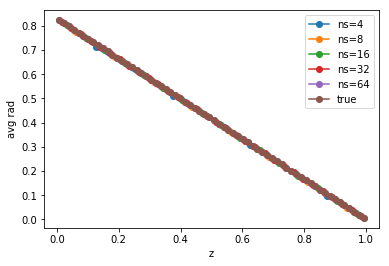

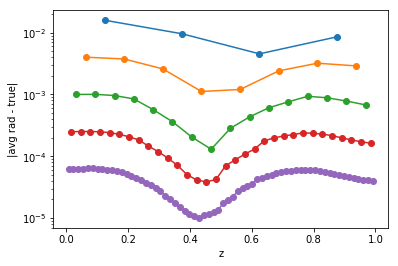

In [332]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

plt.figure(1)
plt.figure(2)

for ns in ns_list:
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
    )
    
    p = 13

    results = results_list[0]
    rad = results['rad'][:][:,:,:,p]
    true_rad = results['true_rad'][:][:,:,:,p]

    avg_rad = np.mean(rad, axis=(0, 1))
    avg_true_rad = np.mean(true_rad, axis=(0, 1))

    err = norm(rad - true_rad)

    print("err = {:.2f}".format(err))


    _, _, z, _, _ = mms.gen_grid(
        *map(
            lambda x: int(results[x][:].data),
            ('ns', 'nz', 'ntheta', 'nphi', 'rope_spacing', 'zmax')
        )
    )

    z = z[0,0,:,0]

    plt.figure(1)
    plt.plot(z, avg_rad, 'o-', label='ns={}'.format(ns))
    
    plt.figure(2)
    plt.semilogy(z, np.abs(avg_rad - avg_true_rad), 'o-', label='ns={}'.format(ns))

plt.figure(1)
plt.plot(z, avg_true_rad, 'o-', label='true')
plt.legend()
plt.xlabel('z')
plt.ylabel('avg rad')

plt.figure(2)
plt.xlabel('z')
plt.ylabel('|avg rad - true|')

##### err. vs. ds

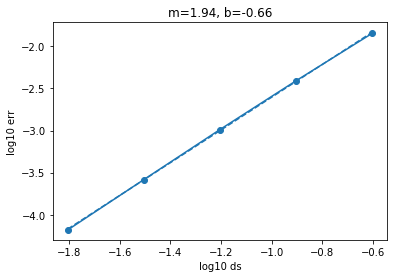

In [333]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
dim_dict = dict(zip(dim_names, dim_resolutions))

ns_list = dim_dict['ns']

err_dict = {}
for i, ns in enumerate(ns_list):
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns,
        nz=ns,
    )

    rad = results_list[0]['rad'][:]
    true_rad = results_list[0]['true_rad'][:]
    compute_time = results_list[0]['compute_time'][:]

    err = norm(rad - true_rad)
    err_dict[ns] = err

res_arr = rope_spacing / np.array(ns_list)
err_arr = np.array([err_dict[ns] for ns in ns_list])

conv.plot_lin_fit(
    np.log10(res_arr), np.log10(err_arr), 
    min(np.log10(res_arr)), max(np.log10(res_arr)), 
    xlabel='log10 ds', ylabel='log10 err'
)

### asym. conv. as $b \to 0$

#### Compute

1D, looks good: verify_asym_uni_a_expb15_L_1x4000x2_scat_0_1_2_3_b_m15_m05 

In [29]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
#base_dir = '/home/oliver/academic/research/kelp-results'

ns = 64
nz = 64
na = 8

num_threads = 32

num_scatters_list = [0, 1, 2, 3]
b_list = np.logspace(-0.5, 0, 10)

study_name = 'mms_verify_asym_and_fd_prod_a_tanhb_L_lin_vsf_{}x{}x{}_scat_0_1_2_3_b_m05_0'.format(ns, nz, na)
study_dir = os.path.join(base_dir, study_name)

ntheta = na
nphi = na

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

combine_thread, gs_fut = kelp_compute.mms_verify_asym_compute(
    study_name, 
    b_list, num_scatters_list, num_threads,
    ns, nz, ntheta, nphi, 
    rope_spacing, zmax, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    param_vals, do_fd=True, base_dir=base_dir)

Appending existing study directory.
Running asym.: (0.32,  0)
Running asym.: (0.32,  1)
Running asym.: (0.32,  2)
Running asym.: (0.32,  3)
Running asym.: (0.36,  0)
Running asym.: (0.36,  1)
Running asym.: (0.36,  2)
Running asym.: (0.36,  3)
Running asym.: (0.41,  0)
Running asym.: (0.41,  1)
Running asym.: (0.41,  2)
Running asym.: (0.41,  3)
Running asym.: (0.46,  0)
Running asym.: (0.46,  1)
Running asym.: (0.46,  2)
Running asym.: (0.46,  3)
Running asym.: (0.53,  0)
Running asym.: (0.53,  1)
Running asym.: (0.53,  2)
Running asym.: (0.53,  3)
Running asym.: (0.60,  0)
Running asym.: (0.60,  1)
Running asym.: (0.60,  2)
Running asym.: (0.60,  3)
Running asym.: (0.68,  0)
Running asym.: (0.68,  1)
Running asym.: (0.68,  2)
Running asym.: (0.68,  3)
Running asym.: (0.77,  0)
Running asym.: (0.77,  1)
Running asym.: (0.77,  2)
Running asym.: (0.77,  3)
Running asym.: (0.88,  0)
Running asym.: (0.88,  1)
Running asym.: (0.88,  2)
Running asym.: (0.88,  3)
Running asym.: (1.00,  0)
Ru

KeyboardInterrupt: 

#### Plot

In [37]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
#study_name = 'verify_asym_prod_a_tanhb_L_lin_vsf_64x64x8_scat_0_1_2_3_b_m05_2'
#study_name = 'verify_asym_prod_a_tanhb_L_lin_vsf_smallderiv_64x64x8_scat_0_1_2_3_b_m05_0'
#study_name = 'verify_asym_prod_a_tanhb_L_lin_vsf_128x128x8_scat_0_1_2_3_b_m05_0'
#study_name = 'mms_verify_asym_and_fd_prod_a_tanhb_L_lin_vsf_32x32x18_scat_0_1_2_3_b_m05_0'
study_name = 'mms_verify_asym_and_fd_prod_a_tanhb_L_lin_vsf_64x64x8_scat_0_1_2_3_b_m05_0'
#study_name = 'mms_verify_asym_and_fd_prod_a_tanhb_L_lin_vsf_10x10x10_scat_0_1_2_3_b_m05_0'
#study_name = 'verify_asym_uni_a_expb15_L_64x64x8_scat_0_1_2_3_b_m15_m05'
study_dir = os.path.join(base_dir, study_name)

In [38]:
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

In [45]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

b_list, num_scatters_list, ns_list, nz_list, na_list = kelp_analyze.get_unique_vals(
    conn, 
    study_name, 
    ['b', 'num_scatters', 'ns', 'nz', 'ntheta']
)
ns = ns_list[0]
nz = nz_list[0]
na = na_list[0]

plt.figure(figsize=[8,6])

b_arr = np.array(b_list)

fd_err_arr = np.zeros([
    len(b_list), 
    len(num_scatters_list), 
    #len(ns_list)
])
asym_err_arr = np.zeros([
    len(b_list), 
    len(num_scatters_list), 
    #len(ns_list)
])
diff_err_arr = np.zeros([
    len(b_list), 
    len(num_scatters_list), 
    #len(ns_list)
])
fd_time_arr = np.zeros([
    len(b_list), 
    len(num_scatters_list), 
    #len(ns_list)
])
asym_time_arr = np.zeros([
    len(b_list), 
    len(num_scatters_list), 
    #len(ns_list)
])

true_rad_list = []
asym_rad_list = []
fd_rad_list = []
i_plot = 5
for k, num_scatters in enumerate(num_scatters_list):
    diff_err_list = []
    asym_err_list = []
    fd_err_list = []
    for i, b in enumerate(b_list):
        asym_results_list = kelp_analyze.query_results(
            conn, study_name, base_dir,
            b=b,
            num_scatters=num_scatters,
            fd_flag=False
        )
        
        fd_results_list = kelp_analyze.query_results(
            conn, study_name, base_dir,
            b=b,
            num_scatters=num_scatters,
            fd_flag=True
        )
        
        asym_rad = asym_results_list[0]['rad'][:]
        true_rad = asym_results_list[0]['true_rad'][:]
        fd_rad = fd_results_list[0]['rad'][:] 

        asym_err = norm(asym_rad - true_rad)
        fd_err = norm(fd_rad - true_rad)
        diff_err = norm(asym_rad - fd_rad)
        # TODO: Use avg. irrad as scalar metric
        #diff_sm_err = np.abs(asym_rad - fd_rad)
        asym_err_list.append(asym_err)
        fd_err_list.append(fd_err)
        diff_err_list.append(diff_err)
        
        asym_time_arr[i, k] = asym_results_list[0]['compute_time'][:].data
        fd_time_arr[i, k] = fd_results_list[0]['compute_time'][:].data
        
        if i == i_plot:
            asym_rad_list.append(asym_rad)
            fd_rad_list.append(fd_rad)
            true_rad_list.append(true_rad)

    fd_err_arr[:, k] = np.array(fd_err_list)[:]
    asym_err_arr[:, k] = np.array(asym_err_list)[:]
    diff_err_arr[:, k] = np.array(diff_err_list)[:]
   

<Figure size 576x432 with 0 Axes>

# Error

asym_err arr 0: [0.03893699 0.04434166 0.05047631 0.05742475 0.06527302 0.07410587
 0.08400186 0.09502668 0.10722488 0.12061028]
fd_err arr 0: [4.20758104e-05 4.45506991e-05 4.74345246e-05 5.07976216e-05
 5.47226074e-05 5.93049802e-05 6.46544507e-05 7.08965770e-05
 7.81724810e-05 8.66402634e-05]
diff_err arr 0: [0.03893967 0.04434461 0.05047956 0.05742835 0.06527702 0.07411035
 0.08400689 0.09503233 0.10723124 0.12061746]
asym_err arr 1: [0.00201018 0.00253906 0.00320565 0.00404567 0.00510407 0.00643834
 0.00812271 0.01025677 0.01296472 0.01640386]
fd_err arr 1: [4.20758104e-05 4.45506991e-05 4.74345246e-05 5.07976216e-05
 5.47226074e-05 5.93049802e-05 6.46544507e-05 7.08965770e-05
 7.81724810e-05 8.66402634e-05]
diff_err arr 1: [0.00201733 0.00254658 0.00321365 0.00405427 0.00511343 0.00644866
 0.00813416 0.0102693  0.01297889 0.01642011]
asym_err arr 2: [0.0007567  0.00108999 0.00157231 0.00226775 0.00326655 0.0046947
 0.00672673 0.00960206 0.01364569 0.01929279]
fd_err arr 2: [4.207

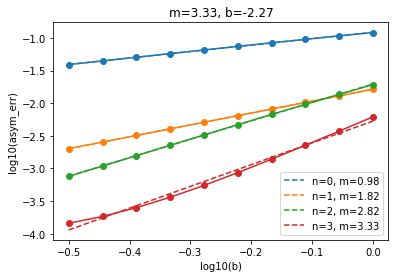

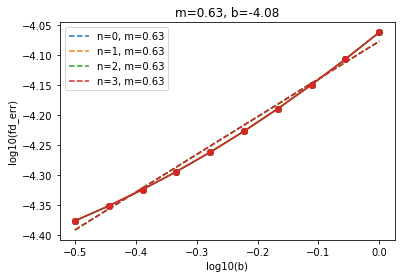

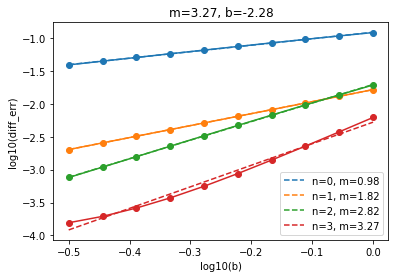

In [199]:
for k, num_scatters in enumerate(num_scatters_list):
    plt.figure(1, figsize=(6, 4))
    plt.title("asym_err")
    print("asym_err arr {}: {}".format(num_scatters, asym_err_arr[:, k]))
    conv.plot_lin_fit(
        np.log10(b_arr), np.log10(asym_err_arr[:, k]), 
        min(np.log(b_arr)), max(np.log(b_arr)), 
        xlabel='log10(b)', ylabel='log10(asym_err)',
        label='n=%d, m={m:.2f}' % num_scatters
    )
    
    plt.figure(2, figsize=(6,4))
    plt.title("fd_err")
    print("fd_err arr {}: {}".format(num_scatters, fd_err_arr[:, k]))
    conv.plot_lin_fit(
        np.log10(b_arr), np.log10(fd_err_arr[:, k]), 
        min(np.log(b_arr)), max(np.log(b_arr)), 
        xlabel='log10(b)', ylabel='log10(fd_err)',
        label='n=%d, m={m:.2f}' % num_scatters
    )
    
    plt.figure(3, figsize=(6, 4))
    plt.title("diff_err")
    print("diff_err arr {}: {}".format(num_scatters, diff_err_arr[:, k]))
    conv.plot_lin_fit(
        np.log10(b_arr), np.log10(diff_err_arr[:, k]), 
        min(np.log(b_arr)), max(np.log(b_arr)), 
        xlabel='log10(b)', ylabel='log10(diff_err)',
        label='n=%d, m={m:.2f}' % num_scatters
    )
    
plt.figure(1)
plt.legend()
plt.savefig('/scratch/kelp-figures/mms_asym_b_conv.pdf')
plt.figure(2)
plt.legend()
plt.figure(3)
plt.legend()

# Time

In [57]:
from matplotlib import cm

In [67]:
cm.plasma(100)

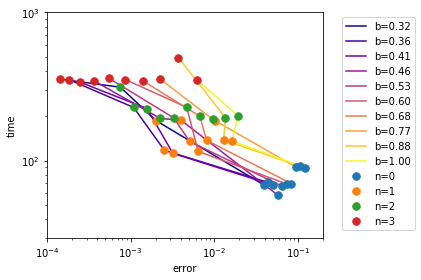

In [143]:
plt.figure(figsize=(6, 4))
for i, b in enumerate(b_arr):
    pcnt = (np.log(b)-np.log(b_arr.min())) / (np.log(b_arr.max())-np.log(b_arr.min()))
    plt.plot(asym_err_arr[i, :], asym_time_arr[i, :], color=cm.plasma(pcnt), label='b={:.2f}'.format(b))
for k, num_scatters in enumerate(num_scatters_list):
    plt.plot(asym_err_arr[:, k], asym_time_arr[:, k], 'C{}o'.format(k), ms=7.5, label='n={}'.format(num_scatters))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('error')
plt.ylabel('time')
plt.xlim(1e-4, 2e-1)
plt.ylim(3e1, 1e3)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.tight_layout()
plt.savefig('/scratch/kelp-figures/mms_asym_err_time.pdf')

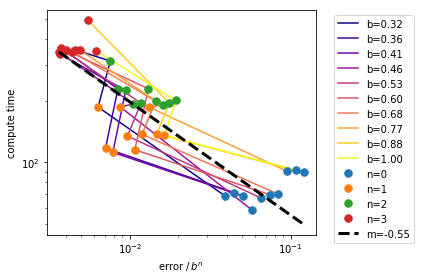

In [197]:
plt.figure(figsize=(6, 4))
b2d = b_arr.reshape(-1, 1)
n2d = np.array(num_scatters_list).reshape(1, -1)
xq = asym_err_arr / b2d**n2d
yq = asym_time_arr
m_lin, b_lin = conv.lin_fit(np.ravel(np.log(xq)), np.ravel(np.log(yq)), np.log(1e-3), np.log(1e-1))
for i, b in enumerate(b_arr):
    pcnt = (np.log(b)-np.log(b_arr.min())) / (np.log(b_arr.max())-np.log(b_arr.min()))
    plt.plot(xq[i,:], yq[i,:], color=cm.plasma(pcnt), label='b={:.2f}'.format(b))
for k, num_scatters in enumerate(num_scatters_list):
    plt.plot(xq[:,k], yq[:,k], 'C{}o'.format(k), ms=7.5, label='n={}'.format(num_scatters))
    
plt.plot(np.array([xq.min(), xq.max()]), np.exp(b_lin)*np.array([xq.min(), xq.max()])**m_lin, 'k--', lw=3, label='m={:.2f}'.format(m_lin))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'error $/\,b^n$')
plt.ylabel('compute time')
#plt.xlim(1e-4, 2e-1)
#plt.ylim(3e1, 1e3)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.tight_layout()
plt.savefig('/scratch/kelp-figures/mms_asym_err_time_collapsed.pdf')

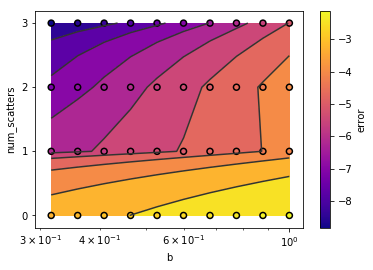

In [219]:
plt.figure(figsize=(6, 4))
b_grid, n_grid = np.meshgrid(b_arr, num_scatters_list, indexing='ij')
color_norm = mpl.colors.LogNorm(vmin=asym_err_arr.min(), vmax=asym_err_arr.max())
nlevels = 10
plt.contourf(
    b_grid, 
    n_grid, 
    asym_err_arr, 
    norm=color_norm, 
    vmin=asym_err_arr.min(), 
    vmax=asym_err_arr.max(), 
    levels=np.logspace(
        np.log10(asym_err_arr.min()),
        np.log10(asym_err_arr.max()),
        nlevels
    ),
    cmap='plasma'
)
plt.contour(
    b_grid, 
    n_grid, 
    asym_err_arr, 
    colors='0.2',
    vmin=asym_err_arr.min(), 
    vmax=asym_err_arr.max(), 
    levels=np.logspace(
        np.log10(asym_err_arr.min()),
        np.log10(asym_err_arr.max()),
        nlevels
    ),
)
plt.scatter(b_grid, n_grid, c=np.log(asym_err_arr), edgecolors='k', linewidths=1.5, cmap='plasma')
plt.xscale('log')
plt.xlabel('b')
plt.ylabel('num_scatters')
plt.yticks(num_scatters_list)
plt.colorbar(label='error', norm=color_norm)
plt.savefig('/scratch/kelp-figures/mms_asym_err_n_contourf.pdf')

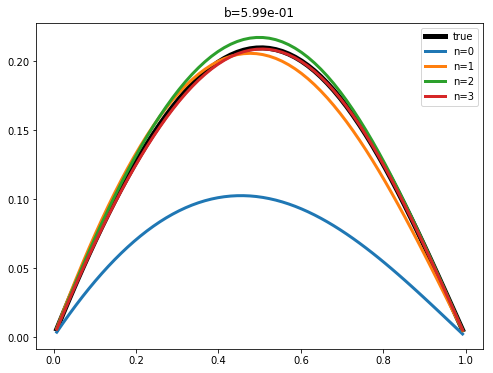

In [33]:
plt.figure(figsize=(8,6))
ns = max(ns_list)
nz = max(nz_list)
na = max(na_list)
grid = mms.gen_grid(ns, nz, na, na, rope_spacing, zmax)
plot_inds = np.zeros_like(grid[2], dtype=bool)
plot_inds[0,0,:,0] = True
z = grid[2][plot_inds]
plt.plot(z, true_rad_list[0][plot_inds], 'k-', lw=5, label='true')
for n in num_scatters_list:
    plt.plot(z, asym_rad_list[n][plot_inds], 'C{}-'.format(n), lw=3, label='n={}'.format(n))

plt.title('b={:.2e}'.format(b_list[i_plot]))
plt.legend()

Plot Taylor Series Error

In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

b_list, num_scatters_list = kelp_analyze.get_unique_vals(conn, study_name, ['b', 'num_scatters'])
#this_sol_expr = sp.parsing.sympy_parser.parse_expr(
#    kelp_analyze.table_to_df(conn, study_name)['source_expr'][0], 
#    local_dict={'gamma': sp.Symbol('gamma')}
#)
tay_term_N = mms.gen_series_N(sol_expr, max(num_scatters_list), **param_vals)
def tay_approx_N(x, y, z, theta, phi, b, n):
    s = 0*(x+y+z+theta+phi)
    for k in range(n+1):
        s += b**k * tay_term_N(x, y, z, theta, phi, k)
    
    return s

fig1 = plt.figure(figsize=[8,6])
ax1 = plt.gca()
fig2 = plt.figure(figsize=[8,6])
ax2 = plt.gca()

tay_rad_list = []
true_rad_list = []
i_plot = 6
for num_scatters in num_scatters_list:
    err_list = []
    for i, b in enumerate(b_list):
        results_list = kelp_analyze.query_results(
            conn, study_name,
            b=b,
            num_scatters=num_scatters,
        )

        ns = results_list[0]['ns'][:].data
        nz = results_list[0]['nz'][:].data
        ntheta = results_list[0]['ntheta'][:].data
        nphi = results_list[0]['nphi'][:].data
        grid = mms.gen_grid(ns, nz, ntheta, nphi, rope_spacing, zmax)

        tay_rad = tay_approx_N(*grid, b, num_scatters)
        #rad = results_list[0]['rad'][:]
        true_rad = results_list[0]['true_rad'][:]

        err = norm(tay_rad - true_rad)
        err_list.append(err)
        
        if i == i_plot:
            tay_rad_list.append(tay_rad)
            true_rad_list.append(true_rad)

    b_arr = np.array(b_list)[:-2]
    err_arr = np.array(err_list)[:-2]
    
    print("err arr {}: {}".format(num_scatters, err_arr))
    plt.sca(ax1)
    conv.plot_lin_fit(
        np.log10(b_arr), np.log10(err_arr), 
        min(np.log(b_arr)), 0*max(np.log(b_arr)), 
        xlabel='log10(b)', ylabel='log10(err)',
        label='n=%d, m={m:.2f}' % num_scatters
    )
    
    
plt.sca(ax1)
plt.title('')
plt.legend()


plt.sca(ax2)
z = grid[2][plot_inds]
plt.plot(z, true_rad_list[0][plot_inds], 'ko-', label='true')
for n in num_scatters_list:
    plt.plot(z, tay_rad_list[n][plot_inds], 'C{}o-'.format(n), label='n={}'.format(n))

plt.title('b={:.2e}'.format(b_list[i_plot]))
plt.legend()


In [ ]:
for n in num_scatters_list:
    print("{}: {:.2e}".format(
        n,
        np.abs(asym_rad_list[n] - tay_rad_list[n]).max()
    ))

In [ ]:
import sys

In [ ]:
sorted(((4,6), (5,1), (6,9)), key=lambda x: x[1])

In [ ]:
del(tay_rad)

In [ ]:
ipc = ipp.Client()

In [ ]:
lv = ipc.load_balanced_view()

In [ ]:
def sz():
    import sys
    return sorted([(n, sys.getsizeof(v)/2**30) for n, v in globals().items()], key=lambda t: t[1], reverse=True)

In [ ]:
fut = lv.apply(sz)

In [ ]:
fut.done()